In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../../../scripts/')
from PreparaDatasetV2 import *

# Parâmetros do método

In [2]:
TARGET = 'Back_Under'
ODDS = 'Odds_Under'

# Carregando o dataset

In [3]:
data = pd.read_csv('../../../data/Entire_Season.csv')
data = prepara_df(data)

In [4]:
def prepara_dataset(_df):
    _df.loc[(_df['Back_Over'] == 1), 'Back_Under'] = 0
    _df.loc[(_df['Back_Over'] == 0), 'Back_Under'] = 1

    _df.replace([np.inf, -np.inf], 0, inplace=True)
    _df.reset_index(drop=True, inplace=True)
    
    return _df

In [5]:
df = data.copy()
df = prepara_dataset(df)

In [6]:
treinamento, val = train_test_split(df, train_size=0.66, random_state=2023)
real_treino, real_teste = train_test_split(treinamento, train_size=0.5, random_state=2023)

print(f'Treino: {real_treino.shape[0]} | Teste: {real_teste.shape[0]} | Validação: {val.shape[0]}')

Treino: 2720 | Teste: 2721 | Validação: 2804


# Criação do modelo

In [79]:
features = ['Over_Line', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 
       'Avg_CG_H', 'DP_CG_H', 'CV_CG_H', 'Avg_Pontos_H',
       'DP_Pontos_H', 'CV_Pontos_H', 'CG_H_Last_Game', 'Media_Odds_Geral_H',
       'DP_Odds_Geral_H', 'CV_Odds_Geral_H', 'Saldo_Gols_H', 'Avg_CG_A',
       'DP_CG_A', 'CV_CG_A', 'Avg_Pontos_A', 'DP_Pontos_A', 'CV_Pontos_A',
       'CG_A_Last_Game', 'Media_Odds_Geral_A', 'DP_Odds_Geral_A',
       'CV_Odds_Geral_A', 'Saldo_Gols_A', 'Goals_Last_H', 'Goals_Last_A',
       'Last_Odd_H', 'Last_Odd_A', 'MediaCustoGolHome', 'MediaCustoGolAway',
       'CV_ML', 'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH',
       'Custo_Retorno_BH', 'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real',
       'Dist_Porc_BH', 'Retornos_BA_Acu', 'Avg_Retornos_BA',
       'Custo_Retorno_BA', 'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real',
       'Dist_Porc_BA']

In [151]:
# Ranges da variável
ranges_dict['CV_ML']['range']

[Interval(-0.001, 0.154, closed='right'),
 Interval(0.154, 0.319, closed='right'),
 Interval(0.319, 0.5, closed='right'),
 Interval(0.5, 1.001, closed='right'),
 Interval(1.001, 1.297, closed='right')]

In [143]:
def filtra_resultados(_df, filtro = 0):

    if filtro == 1:
        _df = _df[((_df['CG_A_Last_Game'] <= 191) | (_df['CG_A_Last_Game'] > 280))]
        _df = _df[((_df['Saldo_Gols_H'] <= 0) | (_df['Saldo_Gols_H'] > 16))]
        _df = _df[((_df['CG_H_Last_Game'] <= 166.6) | (_df['CG_H_Last_Game'] > 260.85))]
        _df = _df[((_df['Avg_CG_H'] <= 262.034) | (_df['Avg_CG_H'] > 969.8))]
        _df = _df[((_df['MediaCustoGolAway'] <= 200.907) | (_df['MediaCustoGolAway'] > 868.35))]
        _df = _df[((_df['P_Diff'] <= 0.0747) | (_df['P_Diff'] > 0.0971))]
        _df = _df[((_df['HA_Odds_A'] >= 0) & (_df['HA_Odds_A'] <= 1.68)) | ((_df['HA_Odds_A'] > 1.8) & (_df['HA_Odds_A'] <= 1.9))]
        _df = _df[((_df['CV_HA'] >= 0) & (_df['CV_HA'] <= 0.162))]
        _df = _df[((_df['Last_Odd_A'] <= 1.297) | (_df['Last_Odd_A'] > 1.62))]
        _df = _df[((_df['P(A)'] <= 0.234) | (_df['P(A)'] > 0.365))]

    return _df

In [11]:
def calcula_profit(_df, stake = 1):
    _df.loc[(_df[TARGET] == 1), 'PL_BF_Predictions'] = (_df[ODDS] - 1) * stake
    _df.loc[(_df[TARGET] == 0), 'PL_BF_Predictions'] = - stake

    return _df

def exibe_metricas(_df, total, stake = 1, return_metrics = False):
    _df['Acumulado'] = _df['PL_BF_Predictions'].cumsum()
    _df['Drawdown'] = _df['Acumulado'] - _df['Acumulado'].cummax()
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df.shape[0]
    wr = round((_df[_df[TARGET] == 1].shape[0] / entradas), 2)
    oddback = (_df[ODDS].mean())
    med_gain = _df[_df[TARGET] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df[TARGET] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)
    dd = _df['Drawdown'].min()

    if return_metrics == False:
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
        print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
        print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
        print(f'EM: {ev:.2f}')
        print(f'Máx Drawndown: {dd:.2f}')
        print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')
    else:
        return_metrics == True
        metrics = {
            'pl': plb,
            'wr': wr,
            'dd': dd,
            'oddback': oddback,
            'med_gain': med_gain,
            'med_loss': med_loss,
            'roi': roi,
            'porc_ent': porc_ent,
            'ev': ev,
        }
        return metrics

def exibe_grafico(_df, per_day = False):
    _df['Date'] = pd.to_datetime(_df['Date'])
    _df.sort_values('Date', inplace=True)
    _df.reset_index(drop=True, inplace=True)
    
    if per_day:
        _df_per_day = _df.groupby(_df['Date'].dt.date)['PL_BF_Predictions'].sum()
        _df_per_day = _df_per_day.reset_index()
        
        # Criar um novo DataFrame com colunas 'Date' e 'Accumulated'
        new_df = pd.DataFrame({
            'Date': _df_per_day['Date'],
            'PL': _df_per_day['PL_BF_Predictions']
        })

        new_df['hbacu'] = new_df['PL'].cumsum()
        new_df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por dia')
        plt.show()

    else:
        _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
        _df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por jogo')
        plt.show()

def treina_modelo(modelo, data):
    _df = predict_model(modelo, data, verbose = False)
    _df = _df.merge(df[[TARGET, 'Date']], left_index=True, right_index=True, how='left')
    if f'{TARGET}_x' in _df.columns.tolist():
        _df.rename(columns={f'{TARGET}_x': TARGET}, inplace=True)
        _df.drop(columns=f'{TARGET}_y', inplace=True)
    if 'Date_x' in _df.columns.tolist():
        _df.rename(columns={'Date_x': 'Date'}, inplace=True)
        _df.drop(columns='Date_y', inplace=True)
    
    return _df

def info_modelo(data, stake = 1, filtro = 0, per_day = False, show_info = True):
    total = data.shape[0]

    _df = filtra_resultados(data, filtro=filtro)
    _df = calcula_profit(_df, stake)
    if show_info:
        exibe_metricas(_df, total, stake)
        exibe_grafico(_df, per_day)
    
    return _df


----------------- TREINO -----------------


----------------- TESTE -----------------
PL: 10.15 | ROI: 5.15% | Prec.: 0.56
Odd média: 1.87 (0.54 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.05
Máx Drawndown: -14.93
197 entradas em 2721 jogos (7.24%)


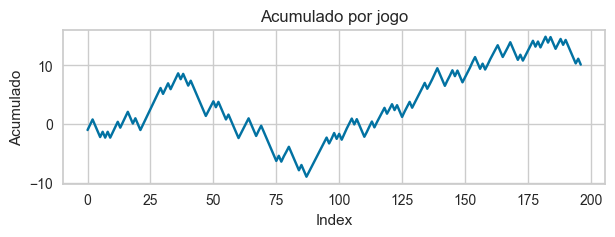



----------------- TREINAMENTO COMPLETO -----------------


----------------- VALIDAÇÃO -----------------
PL: 10.83 | ROI: 6.30% | Prec.: 0.57
Odd média: 1.86 (0.54 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.06
Máx Drawndown: -6.20
172 entradas em 2804 jogos (6.13%)


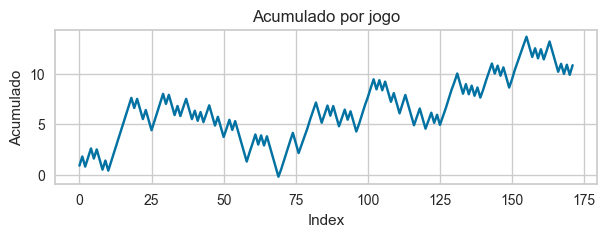

In [144]:
flt = 1

print('----------------- TREINO -----------------')
df_treino = info_modelo(real_treino, filtro = flt, show_info=False)
print('\n\n----------------- TESTE -----------------')
df_teste = info_modelo(real_teste, filtro = flt, show_info=True)
print('\n\n----------------- TREINAMENTO COMPLETO -----------------')
df_treinamento = info_modelo(treinamento, filtro = flt, show_info=False)
print('\n\n----------------- VALIDAÇÃO -----------------')
df_val = info_modelo(val, filtro = flt, show_info=True)

PL: 47.28 | ROI: 8.44% | Prec.: 0.58
Odd média: 1.86 (0.54 WR)
Média Gain: 0.87 | Média Loss: -1.00
EM: 0.08
Máx Drawndown: -17.62
560 entradas em 8245 jogos (6.79%)


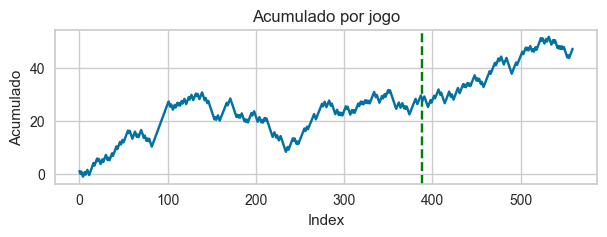

In [145]:
plt.axvline(x=len(pd.concat([df_treino, df_teste])), color='green', linestyle='--')
comp = pd.concat([df_treino, df_teste, df_val])
exibe_metricas(comp, total=len(treinamento) + len(val))
exibe_grafico(comp)

# QCut automático

In [131]:
def find_pos_range(var, treino, teste, validacao, ratio = 0.03):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    treino[nome]  = pd.qcut(treino[var], q = 5)

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(treino,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    ranges = pivot_table[pivot_table['ratio'] > ratio].index.tolist()

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
        
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]
    
    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict


def find_top_range(var, treino, teste, validacao, ratio = 3):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    treino[nome]  = pd.qcut(treino[var], q = 5)

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(treino,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()

    ranges = ranges[:ratio]

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
    
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]

    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict


def find_neg_range(var, treino, teste, validacao):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    treino[nome]  = pd.qcut(treino[var], q = 5)

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(treino,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()
    
    # Pegar apenas o primeiro intervalo da lista
    range = ranges[0]

    # Criar a máscara booleana para valores dentro do primeiro intervalo
    mascara_treino = treino[var].apply(lambda x: x in range)
    mascara_teste = teste[var].apply(lambda x: x in range)
    mascara_val = validacao[var].apply(lambda x: x in range)

    mascara_treino = ~mascara_treino
    mascara_teste = ~mascara_teste
    mascara_val = ~mascara_val
    
    # Aplicar a máscara para obter o DataFrame filtrado
    treino_filtrado = treino[mascara_treino]
    teste_filtrado = teste[mascara_teste]
    val_filtrado = validacao[mascara_val]
    
    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = range
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict

In [146]:
autocut_treino = df_treino.copy()
autocut_teste = df_teste.copy()
autocut_val = df_val.copy()

In [155]:
variaveis = features.copy()
ranges_dict = {}

for var in variaveis:
    try:
        # new_dict = find_pos_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 0.07)
        new_dict = find_neg_range(var, treino = autocut_treino, teste = autocut_teste, validacao=autocut_val)
        # new_dict = find_top_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 3)
        ranges_dict[var] = new_dict
    except:
        pass

ordenado = {chave: valor for chave, valor in sorted(ranges_dict.items(), key=lambda item: item[1]['metric_teste']['wr'], reverse=True)}

In [156]:
for var in ordenado:
    print(f'{var}')
    print(f'treino: {ordenado[var]["metric_treino"]["wr"]:.2f}')
    # print(f'treino: {ordenado[var]["metric_treino"]["pl"]:.2f}')
    print(f'teste: {ordenado[var]["metric_teste"]["wr"]:.2f}')
    # print(f'teste: {ordenado[var]["metric_teste"]["pl"]:.2f}')
    print(f'val: {ordenado[var]["metric_val"]["wr"]:.2f}')
    # print(f'val: {ordenado[var]["metric_val"]["pl"]:.2f}')
    print(f'% Ent: {ordenado[var]["metric_teste"]["porc_ent"]:.2f}')
    print()

Goals_Last_H
treino: 0.63
teste: 0.59
val: 0.53
% Ent: 0.05

Over_Line
treino: 0.62
teste: 0.58
val: 0.55
% Ent: 0.07

P(H)
treino: 0.63
teste: 0.56
val: 0.56
% Ent: 0.06

P_Diff
treino: 0.62
teste: 0.56
val: 0.58
% Ent: 0.06

HA_Line
treino: 0.62
teste: 0.55
val: 0.57
% Ent: 0.06

P(A)
treino: 0.63
teste: 0.55
val: 0.55
% Ent: 0.06

CV_ML
treino: 0.62
teste: 0.55
val: 0.59
% Ent: 0.06

HA_Odds_H
treino: 0.61
teste: 0.53
val: 0.58
% Ent: 0.06

P(U)
treino: 0.60
teste: 0.51
val: 0.56
% Ent: 0.05



### comparação geral

In [ ]:
ordenado2 = {chave: valor for chave, valor in sorted(ranges_dict.items(), key=lambda item: item[1]['metric_val']['pl'], reverse=True)}

for var in ordenado2:
    print(f'{var}')
    print('Treino')
    print(f'WR: {ordenado2[var]["metric_treino"]["wr"]:.2f}')
    print(f'PL: {ordenado2[var]["metric_treino"]["pl"]:.2f}')
    print(f'ROI: {ordenado2[var]["metric_treino"]["roi"]:.2f}')
    print(f'DD: {ordenado2[var]["metric_treino"]["dd"]:.2f}')
    print(f'% Ent: {ordenado2[var]["metric_treino"]["porc_ent"]:.2f}')
    print()
    print('Teste')
    print(f'WR: {ordenado2[var]["metric_teste"]["wr"]:.2f}')
    print(f'PL: {ordenado2[var]["metric_teste"]["pl"]:.2f}')
    print(f'ROI: {ordenado2[var]["metric_teste"]["roi"]:.2f}')
    print(f'DD: {ordenado2[var]["metric_teste"]["dd"]:.2f}')
    print(f'% Ent: {ordenado2[var]["metric_teste"]["porc_ent"]:.2f}')
    print()
    print('Val')
    print(f'WR: {ordenado2[var]["metric_val"]["wr"]:.2f}')
    print(f'PL: {ordenado2[var]["metric_val"]["pl"]:.2f}')
    print(f'ROI: {ordenado2[var]["metric_val"]["roi"]:.2f}')
    print(f'DD: {ordenado2[var]["metric_val"]["dd"]:.2f}')
    print(f'% Ent: {ordenado2[var]["metric_val"]["porc_ent"]:.2f}')
    print()
    print('------------------------------------------------\n')

# Comparação de modelos

### Escolhendo os modelos

In [ ]:
def compare(conjunto, modelo, filtro, i):
    try:
        if conjunto == 'val':
            print(f'{modelo.__class__.__name__} (i = {i})\n')
            aux = info_modelo(modelo, val, filtro = filtro)
        elif conjunto == 'teste_val':
            print(f'{modelo.__class__.__name__} (i = {i})\n')
            
            aux_total = info_modelo(modelo, real_teste, filtro = filtro, show_info=False)
            plt.axvline(x=len(aux_total), color='green', linestyle='--')
            aux = info_modelo(modelo, pd.concat([real_teste, val]), filtro = filtro)
        elif conjunto == 'teste':
            print(f'{modelo.__class__.__name__} (i = {i})\n')
            aux = info_modelo(modelo, real_teste, filtro = filtro)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass
    print('\n')

In [ ]:
FILTRO = 1
CONJUNTO = 'teste_val'

In [ ]:
for i in range(14):
    compare(CONJUNTO, top[i], FILTRO, i)

In [ ]:
blended14 = blend_models(estimator_list = [top[1], top[4]], fold = 5, verbose=False)

In [ ]:
model_list = [top[1], top[4], blended14]

### Resultados

In [ ]:
FILTRO = 1
CONJUNTO = 'teste_val'

for i in range(14):
    try:
        if CONJUNTO == 'val':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_total = treina_modelo(top[i], val1)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total), color='red', linestyle='--')
            aux = info_modelo(top[i], val, filtro = FILTRO)
        elif CONJUNTO == 'teste_val':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_total = treina_modelo(top[i], real_teste)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total), color='red', linestyle='--')
            aux = info_modelo(top[i], pd.concat([real_teste, val]), filtro = FILTRO)
        elif CONJUNTO == 'teste':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux = info_modelo(top[i], real_teste, filtro = FILTRO)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass

# Script qcut

In [ ]:
# df_cut1 = df_treino.copy()
df_cut = df_treino.copy()
# df_cut = pd.concat([df_cut1, df_cut2])

In [ ]:
variaveis = features.copy()

for var in variaveis:
    try:
        nome = f'Cat_{var}'
        # Usa qcut para definir os grupos
        df_cut[nome]  = pd.qcut(df_cut[var], q = 5, duplicates='drop')

        target = 'PL_BF_Predictions'
        pivot_table = pd.pivot_table(df_cut,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['sum', 'count']
                                    )
        

        pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

        aux_treino = pivot_table[pivot_table['ratio'] != 0]


        print(var)
        print(aux_treino)
        print()
        print('\n\n')
        print('------------------------------------------------')
        print('\n\n')
    except:
        pass